<a href="https://colab.research.google.com/github/mayanlong2020/ColabDesign/blob/main/%E5%AE%98%E6%96%B9demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RFdiffusion**
RFdiffusion is a method for structure generation, with or without conditional information (a motif, target etc). It can perform a whole range of protein design challenges as we have outlined in the RFdiffusion [manuscript](https://www.biorxiv.org/content/10.1101/2022.12.09.519842v2).

**<font color="red">NOTE:</font>** This notebook is in development, we are still working on adding all the options from the manuscript above.

For **instructions**, see end of Notebook.

See [diffusion_foldcond](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion_foldcond.ipynb) for fold conditioning functionality.

See [original version](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion_ori.ipynb) of this notebook (from 31Mar2023).



In [1]:
#@title 【终极一体化】安装与环境初始化 (v9.6 - 最终修正版)
# ==============================================================================
# v9.6 更新日志:
# - 【终极修正】根据确凿的错误日志，修正了对 AlphaFold tar 压缩包内部结构的
#   错误假设。脚本现在正确地从解压目录的根部查找模型文件，而不是从一个
#   不存在的 'params' 子目录中。这从根本上解决了 FileNotFoundError。
# ==============================================================================
import os
import sys
import subprocess
import shutil
from google.colab import drive

# --- 1. 基础设置与挂载 Drive ---
print("➡️ 正在挂载 Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive 挂载成功！")

# --- 2. 定义持久化路径并创建目录结构 ---
REAL_PLATFORM_ROOT = "/content/drive/My Drive/AI_Projects/Protein_Design_Platform"
REPOS_PATH = os.path.join(REAL_PLATFORM_ROOT, "repositories")
PARAMS_PATH = os.path.join(REAL_PLATFORM_ROOT, "params")
OUTPUTS_PATH = os.path.join(REAL_PLATFORM_ROOT, "outputs")
COLABDESIGN_PARAMS_PATH = os.path.join(PARAMS_PATH, "colabdesign")
RFDIFFUSION_PARAMS_PATH = os.path.join(PARAMS_PATH, "rfdiffusion")
print(f"\n➡️ 正在检查并创建持久化目录结构于: {REAL_PLATFORM_ROOT}")
for path in [REPOS_PATH, COLABDESIGN_PARAMS_PATH, RFDIFFUSION_PARAMS_PATH, OUTPUTS_PATH]:
    os.makedirs(path, exist_ok=True)
print("✅ 持久化目录结构准备就绪。")

# --- 3. 定义健壮的命令执行函数 ---
def run_command(command, description, cwd=None):
    print(f"➡️ 正在执行: {description}...")
    result = subprocess.run(command, shell=True, capture_output=True, text=True, cwd=cwd)
    if result.returncode != 0:
        print(f"❌ 执行失败: {description}\n{result.stderr}")
        raise RuntimeError(f"命令执行失败: {description}")
    else:
        print(f"✅ {description} 完成。")

# --- 4. 克隆和安装核心软件 (如果不存在) ---
print("\n➡️ 正在检查、克隆并配置核心软件...")
COLABDESIGN_REPO_PATH = os.path.join(REPOS_PATH, "colabdesign")
if not os.path.isdir(COLABDESIGN_REPO_PATH): run_command(f"git clone https://github.com/sokrypton/ColabDesign.git '{COLABDESIGN_REPO_PATH}'", "克隆 ColabDesign")
else: print("✅ ColabDesign 仓库已存在。")
RFDIFFUSION_REPO_PATH = os.path.join(REPOS_PATH, "rfdiffusion")
if not os.path.isdir(RFDIFFUSION_REPO_PATH): run_command(f"git clone https://github.com/sokrypton/RFdiffusion.git '{RFDIFFUSION_REPO_PATH}'", "克隆 RFdiffusion")
else: print("✅ RFdiffusion 仓库已存在。")
run_command(f"chmod +x '{os.path.join(RFDIFFUSION_REPO_PATH, 'run_inference.py')}'", "为 RFdiffusion 主脚本添加执行权限")
ANANAS_DRIVE_PATH = os.path.join(RFDIFFUSION_REPO_PATH, "ananas")
if not os.path.exists(ANANAS_DRIVE_PATH):
    ANANAS_TMP_PATH = "/tmp/ananas"; run_command(f"wget -qO {ANANAS_TMP_PATH} https://files.ipd.uw.edu/krypton/ananas", "下载Ananas"); run_command(f"chmod +x {ANANAS_TMP_PATH}", "赋予Ananas权限"); shutil.move(ANANAS_TMP_PATH, ANANAS_DRIVE_PATH)
    print("   - ✅ Ananas 已成功移动到持久化目录。")
else: print("✅ Ananas 已存在。")

# --- 5. 下载模型参数到 Google Drive (如果不存在) ---
print("\n➡️ 正在检查并下载模型参数...")
run_command("apt-get -qq install aria2", "安装或确认 aria2")

# 下载 AlphaFold 参数 (采用 v9.6 最终修正逻辑)
AF_PARAMS_DONE_FILE = os.path.join(COLABDESIGN_PARAMS_PATH, "done.txt")
if not os.path.exists(AF_PARAMS_DONE_FILE):
    print("   - 发现 AlphaFold 参数缺失，开始下载和解压...")
    AF_TAR_PATH = "/tmp/alphafold_params_2022-12-06.tar"
    TMP_UNPACK_DIR = "/tmp/af_params_unpacked"
    # 步骤 1: 下载到本地
    run_command(f"aria2c -q -x 16 -o {os.path.basename(AF_TAR_PATH)} -d /tmp https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar", "1. 下载AlphaFold参数包到本地")
    os.makedirs(TMP_UNPACK_DIR, exist_ok=True)
    # 步骤 2: 解压到本地
    run_command(f"tar -xf {AF_TAR_PATH} -C '{TMP_UNPACK_DIR}'", "2. 解压到本地临时目录")

    # 【v9.6 核心修正】直接从解压目录的根部移动文件
    source_dir_for_move = TMP_UNPACK_DIR
    target_dir_for_move = COLABDESIGN_PARAMS_PATH
    files_to_move = os.listdir(source_dir_for_move)
    print(f"3. 发现 {len(files_to_move)} 个参数文件，准备使用 Python 逐个移动到云端硬盘...")
    for filename in files_to_move:
        src_path = os.path.join(source_dir_for_move, filename)
        dst_path = os.path.join(target_dir_for_move, filename)
        shutil.move(src_path, dst_path)
    print("   - ✅ 所有文件移动成功。")

    # 步骤 4: 标记完成并清理
    run_command(f"touch '{AF_PARAMS_DONE_FILE}'", "4. 标记下载完成")
    os.remove(AF_TAR_PATH)
    shutil.rmtree(TMP_UNPACK_DIR)
else:
    print("✅ AlphaFold 参数已存在，跳过下载。")

# 下载 RFdiffusion 参数 (这部分逻辑是可靠的，无需修改)
RF_PARAMS_DONE_FILE = os.path.join(RFDIFFUSION_PARAMS_PATH, "done.txt")
if not os.path.exists(RF_PARAMS_DONE_FILE):
    print("   - 发现 RFdiffusion 参数缺失，开始下载...")
    run_command(f"aria2c -q -x 16 -d '{RFDIFFUSION_PARAMS_PATH}' https://files.ipd.uw.edu/krypton/schedules.zip", "下载schedules.zip")
    run_command(f"aria2c -q -x 16 -d '{RFDIFFUSION_PARAMS_PATH}' http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt", "下载Base_ckpt.pt")
    run_command(f"aria2c -q -x 16 -d '{RFDIFFUSION_PARAMS_PATH}' http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt", "下载Complex_base_ckpt.pt")
    run_command(f"aria2c -q -x 16 -d '{RFDIFFUSION_PARAMS_PATH}' http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt", "下载Complex_beta_ckpt.pt")
    run_command(f"aria2c -q -x 16 -d '{RFDIFFUSION_PARAMS_PATH}' http://files.ipd.uw.edu/pub/RFdiffusion/42baf007e5c5464ca5de5597793de964/ActiveSite_ckpt.pt", "下载ActiveSite_ckpt.pt")
    run_command(f"unzip -q -o schedules.zip && rm schedules.zip", "解压schedules", cwd=RFDIFFUSION_PARAMS_PATH)
    run_command(f"touch '{RF_PARAMS_DONE_FILE}'", "标记RFdiffusion参数下载完成")
else:
    print("✅ RFdiffusion 参数已存在，跳过下载。")
RF_MODELS_LINK = os.path.join(RFDIFFUSION_REPO_PATH, "models")
if not os.path.lexists(RF_MODELS_LINK): os.symlink(RFDIFFUSION_PARAMS_PATH, RF_MODELS_LINK); print("✅ 已为 RFdiffusion/models 创建符号链接。")

# --- 6. 安装 Python 依赖 ---
print("\n➡️ 正在安装 Python 依赖包...")
os.environ["DGLBACKEND"] = "pytorch"
run_command("pip -q install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator", "安装基础依赖")
run_command("pip -q install git+https://github.com/NVIDIA/dllogger#egg=dllogger", "安装 dllogger")
run_command("pip -q install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html", "安装 dgl")
run_command("pip -q install --no-dependencies e3nn==0.5.5 opt_einsum_fx", "安装 e3nn")
SE3_REPO_PATH = os.path.join(RFDIFFUSION_REPO_PATH, "env", "SE3Transformer")
run_command(f"pip -q install -e '{SE3_REPO_PATH}'", "安装 SE3Transformer (可编辑模式)")
run_command(f"pip -q install -e '{COLABDESIGN_REPO_PATH}'", "安装 ColabDesign (可编辑模式)")

# --- 7. 为当前会话创建 1:1 仿真环境 ---
print("\n➡️ 正在为当前会话创建 1:1 仿真链接...")
os.chdir("/content")
links_to_create = { "RFdiffusion": RFDIFFUSION_REPO_PATH, "colabdesign": os.path.join(COLABDESIGN_REPO_PATH, "colabdesign"), "se3_transformer": os.path.join(SE3_REPO_PATH, "se3_transformer"), "ananas": ANANAS_DRIVE_PATH, "params": COLABDESIGN_PARAMS_PATH, "outputs": OUTPUTS_PATH }
for link_name, real_path in links_to_create.items():
    if os.path.lexists(link_name): os.remove(link_name)
    os.symlink(real_path, link_name)
    print(f"   - [✓] 仿真链接 '{link_name}'")

# --- 8. 设置 Python 路径并最终验证 ---
if "/content/RFdiffusion" not in sys.path: sys.path.append("/content/RFdiffusion")
print("\n➡️ 正在进行最终环境验证...")
try:
    from se3_transformer.model import SE3Transformer; print("   - [✓] se3_transformer 导入成功。")
    from inference.utils import parse_pdb; print("   - [✓] RFdiffusion 核心模块导入成功。")
    from colabdesign.rf.utils import get_ca; print("   - [✓] ColabDesign 核心模块导入成功。")
    print("\n✅✅✅ [终极一体化] 环境设置完毕！您可以开始复刻官方 Notebook 了。✅✅✅")
except ImportError as e:
    print(f"\n❌ 环境初始化失败: {e}")

➡️ 正在挂载 Google Drive...
Mounted at /content/drive
✅ Google Drive 挂载成功！

➡️ 正在检查并创建持久化目录结构于: /content/drive/My Drive/AI_Projects/Protein_Design_Platform
✅ 持久化目录结构准备就绪。

➡️ 正在检查、克隆并配置核心软件...
✅ ColabDesign 仓库已存在。
✅ RFdiffusion 仓库已存在。
➡️ 正在执行: 为 RFdiffusion 主脚本添加执行权限...
✅ 为 RFdiffusion 主脚本添加执行权限 完成。
✅ Ananas 已存在。

➡️ 正在检查并下载模型参数...
➡️ 正在执行: 安装或确认 aria2...
✅ 安装或确认 aria2 完成。
   - 发现 AlphaFold 参数缺失，开始下载和解压...
➡️ 正在执行: 1. 下载AlphaFold参数包到本地...
✅ 1. 下载AlphaFold参数包到本地 完成。
➡️ 正在执行: 2. 解压到本地临时目录...
✅ 2. 解压到本地临时目录 完成。
3. 发现 16 个参数文件，准备使用 Python 逐个移动到云端硬盘...
   - ✅ 所有文件移动成功。
➡️ 正在执行: 4. 标记下载完成...
✅ 4. 标记下载完成 完成。
✅ RFdiffusion 参数已存在，跳过下载。

➡️ 正在安装 Python 依赖包...
➡️ 正在执行: 安装基础依赖...
✅ 安装基础依赖 完成。
➡️ 正在执行: 安装 dllogger...
✅ 安装 dllogger 完成。
➡️ 正在执行: 安装 dgl...
✅ 安装 dgl 完成。
➡️ 正在执行: 安装 e3nn...
✅ 安装 e3nn 完成。
➡️ 正在执行: 安装 SE3Transformer (可编辑模式)...
✅ 安装 SE3Transformer (可编辑模式) 完成。
➡️ 正在执行: 安装 ColabDesign (可编辑模式)...
✅ 安装 ColabDesign (可编辑模式) 完成。

➡️ 正在为当前会话创建 1:1 仿真链接...
   - [✓] 仿真链接 'RFdiffusion'
   - [✓] 仿真链接 'col

/content/RFdiffusion/Track_module.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


   - [✓] RFdiffusion 核心模块导入成功。
   - [✓] ColabDesign 核心模块导入成功。

✅✅✅ [终极一体化] 环境设置完毕！您可以开始复刻官方 Notebook 了。✅✅✅


In [2]:
#@title 预定义函数
import os, time, signal
import sys, random, string, re
from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

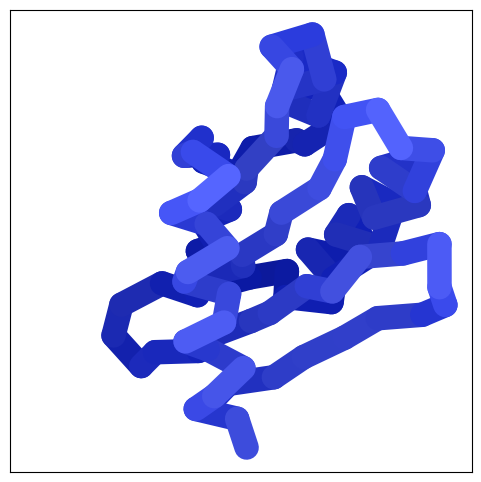

CPU times: user 4.53 s, sys: 86.4 ms, total: 4.61 s
Wall time: 1min 44s


In [3]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "test" #@param {type:"string"}
contigs = "100" #@param {type:"string"}
pdb = "" #@param {type:"string"}
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "" #@param {type:"string"}
num_designs = 1 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **symmetry** settings
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` enables automatic symmetry dectection with [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` filter PDB input to these chains (may help auto-symm detector)
#@markdown - `add_potential` to discourage clashes between chains
#@markdown ---
#@markdown **advanced** settings
#@markdown ---
partial_T = "auto" # @param ["auto", "10", "20", "40", "60", "80"]
#@markdown - specify number of noising steps (only used for the partial diffusion protocol)
use_beta_model = True #@param {type:"boolean"}
#@markdown - if you are seeing lots of helices, switch to the "beta" params for a better SSE balance.

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

In [4]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
#@markdown ProteinMPNN Settings
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
#@markdown - `mpnn_sampling_temp` - control diversity of sampled sequences. (higher = more diverse).
#@markdown - `rm_aa='C'` - do not use [C]ysteines.
#@markdown - `use_solubleMPNN` - use weights trained only on soluble proteins. See [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown
#@markdown AlphaFold Settings
initial_guess = False #@param {type:"boolean"}
#@markdown - soft initialization with desired coordinates, see [paper](https://www.nature.com/articles/s41467-023-38328-5).
num_recycles = 1 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`
use_multimer = False #@param {type:"boolean"}
#@markdown - `use_multimer` - use AlphaFold Multimer v3 params for prediction.

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

{'pdb':'outputs/test_n5kaq_0.pdb','loc':'outputs/test_n5kaq','contigs':'100-100','copies':1,'num_seqs':8,'initial_guess':False,'use_multimer':False,'use_soluble':False,'num_recycles':1,'rm_aa':'C','num_designs':1,'mpnn_sampling_temp':0.1}
protocol=fixbb
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.045 plddt:0.847 ptm:0.721 pae:5.438 rmsd:1.405 MVKIYKKNENTEEIVVEEKEGEPTTLYIAVDSSSEGIEDSIELLLEILEELKGKKVKVVLGVDSEESREKIKEKIPDAEVEFVSMEEVKKKIEELKEKYK
design:0 n:1 mpnn:1.132 plddt:0.470 ptm:0.358 pae:14.495 rmsd:10.670 TVELRQRNEKTATIVLERREGGPDVLYVSVDSESEGIEYTEELLLEILEELEGRPVVVVLGVDSEEARERIKERIEDEEVIFLPMEEVEKLIRELIEKAK
design:0 n:2 mpnn:1.107 plddt:0.657 ptm:0.519 pae:11.173 rmsd:6.641 EVRLRQKNEKTATVVLERKEGEPDVLYVAVDSKSPGKEETFKLVLEILEELKGREVVVVLGVDSEKDIEEFKKLLKDAKLIVKSMEEVQRLIDELKRLAK
design:0 n:3 mpnn:1.125 plddt:0.562 ptm:0.411 pae:12.548 rmsd:12.108 MVEIRQKNKKTATIVIERKEGGPDTLYVLVDSSSEGIKYTVEELLEIIEELKGRKVKVVLGIDSEEAREEVKKKIKDEEVIWVSPEEVQKLIEELKKKYE
design:0 n:4 mpnn:1.090 p

In [6]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive,
#@markdown try disabling your adblocker and run this cell again.
#@markdown  If that fails click on the little folder icon to the
#@markdown  left, navigate to file: `name.result.zip`,
#@markdown  right-click and select \"Download\"
#@markdown (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
!zip -r {path}.result.zip outputs/{path}* outputs/traj/{path}*
files.download(f"{path}.result.zip")

**Instructions**
---
---

Use `contigs` to define continious chains. Use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:

**unconditional**
- `contigs='100'` - diffuse **monomer** of length 100
- `contigs='50:100'` - diffuse **hetero-oligomer** of lengths 50 and 100
- `contigs='50'` `symmetry='cyclic'` `order=2` - make two copies of the defined contig(s) and add a symmetry constraint, for **homo-oligomeric** diffusion.

**binder design**
- `contigs='A:50'` `pdb='4N5T'` - diffuse a **binder** of length 50 to chain A of defined PDB.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).

**motif scaffolding**
 - `contigs='40/A163-181/40'` `pdb='5TPN'`
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - diffuse a loop of length 36 between two segments of defined PDB ranges.

**partial diffusion**
- `contigs=''` `pdb='6MRR'` - noise all coordinates
- `contigs='A1-10'` `pdb='6MRR'` - keep first 10 positions fixed, noise the rest
- `contigs='A'` `pdb='1SSC'` - fix chain A, noise the rest

*hints and tips*
- `pdb=''` leave blank to get an upload prompt
- `contigs='50-100'` use dash to specify a range of lengths to sample from